In [1]:
import tensorflow as tf
tf.__version__
tf.compat.v1.disable_eager_execution()

import numpy as np
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Lambda, Conv1D, maximum, GlobalMaxPooling1D, Dense, GaussianNoise, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import pandas as pd
import logomaker

import random
import tqdm
from subprocess import Popen, PIPE, run
import sys
import pickle
from pyfaidx import Fasta
from  tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
import random
import glob

In [2]:
#Models
def construct_model(num_kernels=32,
                    kernel_width=24,
                    seq_len=None,
                    dropout_prop=0.0,
                    use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.0001, seed=12),
                    optimizer='adam',
                    activation='linear',
                    num_classes=1,
                    l1_reg=0.0,
                    l2_reg= 0.0,
                    gaussian_noise = 0.1,
                    spatial_dropout = 0.0,
                    rc = True,
                    padding="same",
                    conv_name="shared_conv"):
    if rc:
        seq_input = Input(shape=(seq_len,4))
        rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
        seq_rc = rc_op(seq_input)
        if gaussian_noise > 0.0:
            noisy_seq = GaussianNoise(gaussian_noise)(seq_input)
            noisy_seq_rc = rc_op(noisy_seq)
        
        shared_conv = Conv1D(num_kernels, kernel_width,
                             strides=1, padding=padding, 
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             kernel_regularizer=regularizers.l1_l2(l1=l1_reg,
                                                                   l2=l2_reg),
                             bias_initializer='zeros',
                             name=conv_name)

        if gaussian_noise > 0:
            conv_for = shared_conv(noisy_seq)
            conv_rc = shared_conv(noisy_seq_rc)
        else:
            conv_for = shared_conv(seq_input)
            conv_rc = shared_conv(seq_rc)
            

        merged = maximum([conv_for, conv_rc])
        pooled = GlobalMaxPooling1D()(merged)
        if dropout_prop > 0.0:
            dropout = Dropout(dropout_prop)(pooled)
            output = Dense(1, activation='sigmoid',
                       use_bias=True,
                       kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                       kernel_constraint=non_neg(), 
                       bias_initializer='zeros',
                       name="dense_1")(dropout)
        else:
            output = Dense(1, activation='sigmoid',
                           use_bias=True,
                           kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                           kernel_constraint=non_neg(), 
                           bias_initializer='zeros',
                           name="dense_1")(pooled)
        model = Model(inputs=seq_input, outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model



def construct_scan_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'scan_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_seq = conv(seq)
    
    
    model = Model(inputs=seq, outputs=conv_seq)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer('scan_conv').set_weights([conv_weights])
    return model


def construct_score_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
    seq_rc = rc_op(seq)
    
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'score_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=use_bias, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_for = conv(seq)
    conv_rc = conv(seq_rc)
    
    merged = maximum([conv_for, conv_rc])
    pooled = GlobalMaxPooling1D()(merged)
    model = Model(inputs=seq, outputs=pooled)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer("score_conv").set_weights([conv_weights])
    print(model.summary())
    return model

In [3]:
# altschulEriksonDinuclShuffle.py
# P. Clote, Oct 2003

def computeCountAndLists(s):

    #Initialize lists and mono- and dinucleotide dictionaries
    List = {} #List is a dictionary of lists
    List['A'] = []; List['C'] = [];
    List['G'] = []; List['T'] = [];
    # FIXME: is this ok?
    List['N'] = []
    nuclList   = ["A","C","G","T","N"]
    s       = s.upper()
    #s       = s.replace("U","T")
    nuclCnt    = {}  #empty dictionary
    dinuclCnt  = {}  #empty dictionary
    for x in nuclList:
        nuclCnt[x]=0
        dinuclCnt[x]={}
        for y in nuclList:
            dinuclCnt[x][y]=0

    #Compute count and lists
    nuclCnt[s[0]] = 1
    nuclTotal     = 1
    dinuclTotal   = 0
    for i in range(len(s)-1):
        x = s[i]; y = s[i+1]
        List[x].append( y )
        nuclCnt[y] += 1; nuclTotal  += 1
        dinuclCnt[x][y] += 1; dinuclTotal += 1
    assert (nuclTotal==len(s))
    assert (dinuclTotal==len(s)-1)
    return nuclCnt,dinuclCnt,List


def chooseEdge(x,dinuclCnt):
    z = random.random()
    denom=dinuclCnt[x]['A']+dinuclCnt[x]['C']+dinuclCnt[x]['G']+dinuclCnt[x]['T']+dinuclCnt[x]['N']
    numerator = dinuclCnt[x]['A']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['A'] -= 1
        return 'A'
    numerator += dinuclCnt[x]['C']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['C'] -= 1
        return 'C'
    numerator += dinuclCnt[x]['G']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['G'] -= 1
        return 'G'
    numerator += dinuclCnt[x]['T']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['T'] -= 1
        return 'T'
    dinuclCnt[x]['N'] -= 1
    return 'N'

def connectedToLast(edgeList,nuclList,lastCh):
    D = {}
    for x in nuclList: D[x]=0
    for edge in edgeList:
        a = edge[0]; b = edge[1]
        if b==lastCh: D[a]=1
    for i in range(3):
        for edge in edgeList:
            a = edge[0]; b = edge[1]
            if D[b]==1: D[a]=1
    ok = 0
    for x in nuclList:
        if x!=lastCh and D[x]==0: return 0
    return 1

def eulerian(s):
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)
    #compute nucleotides appearing in s
    nuclList = []
    for x in ["A","C","G","T","N"]:
        if x in s: nuclList.append(x)
    #create dinucleotide shuffle L
    firstCh = s[0]  #start with first letter of s
    lastCh  = s[-1]
    edgeList = []
    for x in nuclList:
        if x!= lastCh: edgeList.append( [x,chooseEdge(x,dinuclCnt)] )
    ok = connectedToLast(edgeList,nuclList,lastCh)
    return ok,edgeList,nuclList,lastCh


def shuffleEdgeList(L):
    n = len(L); barrier = n
    for i in range(n-1):
        z = int(random.random() * barrier)
        tmp = L[z]
        L[z]= L[barrier-1]
        L[barrier-1] = tmp
        barrier -= 1
    return L

def dinuclShuffle(s):
    ok = 0
    while not ok:
        ok,edgeList,nuclList,lastCh = eulerian(s)
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)

    #remove last edges from each vertex list, shuffle, then add back
    #the removed edges at end of vertex lists.
    for [x,y] in edgeList: List[x].remove(y)
    for x in nuclList: shuffleEdgeList(List[x])
    for [x,y] in edgeList: List[x].append(y)

    #construct the eulerian path
    L = [s[0]]; prevCh = s[0]
    for i in range(len(s)-2):
        ch = List[prevCh][0]
        L.append( ch )
        del List[prevCh][0]
        prevCh = ch
    L.append(s[-1])
    #t = string.join(L,"")
    t = "".join(L)
    return t


def get_information_content(x):
    ic = x * np.log2((x + .001) / .25)
    if ic > 0:
        return(ic)
    else:
        return(0.0)
    
def get_info_content(ppm):
    w = ppm.shape[0]
    info = np.zeros(w)
    for i in range(w):
        for j in range(4):
            info[i] += ppm[i,j] * np.log2((ppm[i,j] + .001) / 0.25)
    return(info)
    
def trim_ppm(ppm, min_info=0.0):
    info = get_info_content(ppm)
    start_index = 0
    w = ppm.shape[0]
    stop_index = w
    for i in range(w):
        if info[i] < min_info:
            start_index += 1
        else:
            break

    for i in range(w):
        if info[w-i-1] < 0.25:
            stop_index -= 1
        else:
            break

    if np.max(info) < 0.25:
        return(ppm, 0, w)
    else:
        return(ppm[start_index:stop_index,:], start_index, stop_index)
    
DNA_SEQ_DICT = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1],
}

def encode_sequence(seq, N = [0, 0, 0, 0], seq_dict = None, useN = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    if useN == 'uniform':
        N = [(1/len(seq_dict)) for _ in seq_dict]
    elif useN == 'zeros':
        N = [0 for _ in seq_dict]
    d = { **seq_dict, 'N' : N }
    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')
 
def decode_sequence(encoded_seq, seq_dict = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    seq_list = encoded_seq.astype('int').tolist()
    def decode_base(encoded_base):
        for letter,onehot in seq_dict.items():
            if np.array_equal(encoded_base, onehot):
                return letter
        return "N"
    return "".join(decode_base(b) for b in encoded_seq.astype('int'))


In [4]:
from  tensorflow.keras.callbacks import Callback
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2,
                 shape="cosine"):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor
        
        self.shape = shape
        self.history = {}
        self.learning_rates = []

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        #print(fraction_to_restart)
        if self.shape == "cosine":
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        else:
            if fraction_to_restart < 0.5:
                lr = fraction_to_restart * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
            else:
                lr = (1 - fraction_to_restart) * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
        self.learning_rates.append(lr)
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        if self.shape == "cosine":
            K.set_value(self.model.optimizer.lr, self.max_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)
        
class SWA(Callback):

    def __init__(self, epochs_to_train, prop = 0.2, interval = 1):
        super(SWA, self).__init__()
        self.epochs_to_train = epochs_to_train
        self.prop = prop
        self.interval = interval
        self.n_models = 0
        self.epoch = 0
        
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        self.weights = []
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        if epoch % self.interval == 0:
            self.weights.append(self.model.get_weights())
            self.n_models += 1
        else:
            pass

    def on_train_end(self, logs=None):
        num_models_to_average = int(np.ceil(self.prop * self.epoch))
        new_weights = list()
        for weights_list_tuple in zip(*self.weights[-num_models_to_average:]): 
            new_weights.append(
                np.array([np.array(w).mean(axis=0) for w in zip(*weights_list_tuple)])
            )
        self.model.set_weights(new_weights)

In [5]:
class dataGen(Sequence):
    def __init__(self, posSeqs, 
                 posWeights = None,
                 negSeqs=None,
                 batchSize = 32,
                 seqsPerEpoch=20000,
                 padBy = 24):
        
        self.posSeqs = posSeqs
        self.posWeights = posWeights
        self.nPos = len(self.posSeqs)
        
        if negSeqs is not None:
            self.negSeqs = negSeqs
            self.nNeg = len(self.negSeqs)
        else:
            self.negSeqs = None
            
        
        if self.negSeqs is not None:
            self.L = np.max([len(x) for x in self.posSeqs + self.negSeqs])
        else:
            self.L = np.max([len(x) for x in self.posSeqs])
        print("Maximum sequence length = {}".format(self.L))
        
        self.batchSize = batchSize
        self.b2 = self.batchSize // 2
        self.seqsPerEpoch = seqsPerEpoch
        self.padBy = padBy
        
        self.labels = np.array([1 for i in range(self.b2)] + [0 for i in range(self.b2)])
        self.epoch = 0
        self.nIter = 0
        self.shuffleEvery = int(self.nPos // (self.seqsPerEpoch / self.b2) )      
        print(self.shuffleEvery)
    
    def __len__(self):
        return(int(np.floor(self.seqsPerEpoch / self.batchSize)))
    
    def on_epoch_end(self):
        if self.epoch == self.shuffleEvery:
            print("Shuffling positive sequences")
            if self.posWeights is None:
                random.shuffle(self.posSeqs)
            else:
                tmp = list(zip(self.posSeqs, self.posWeights))
                random.shuffle(tmp)
                self.posSeqs, self.posWeights = map(list, zip(*tmp))

    
    def __getitem__(self, index):
        idx = (self.nIter * self.b2) % (self.nPos - self.b2)
        posSample = self.posSeqs[idx:idx+self.b2]
        
        if self.posWeights is not None:
            posWeights = self.posWeights[idx:idx+self.b2]
            
        self.nIter += 1
        
        if self.negSeqs is not None:
            negSample = random.sample(self.negSeqs, self.b2)
        else:
            negSample = [dinuclShuffle(x) for x in posSample]
            if self.posWeights is not None:
                negWeights = posWeights
            
        X = 0.25 * np.ones((self.batchSize, 2*self.padBy + self.L, 4))
        if self.posWeights is not None:
            weights = posWeights + negWeights
            
        for i,seq in enumerate(posSample + negSample):
            l = len(seq)
            start = self.padBy + (self.L - l) // 2
            stop = start + l
            X[i,start:stop,:] = encode_sequence(seq)
            
        if self.posWeights is not None:
            return(X, self.labels, np.array(weights))
        else:
            return(X, self.labels)

In [6]:
TF = "GABPA"
dataFiles = glob.glob("./data/*/" + TF + "/*" )
data = [pd.read_csv(_, header=0, sep="\t").iloc[:-1] for _ in dataFiles]
data = pd.concat(data)

In [7]:
data.head()

,#CHROM,START,END,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name,supporting_peakcallers
0,chr1,100132893,100133369,100133161,46,35.82185,10.65744,31.81486,out_peak_215,"cpics,gem,sissrs"
1,chr1,100266094,100266433,100266279,17,12.18684,6.56712,8.68031,out_peak_216,"cpics,gem,sissrs"
2,chr1,100894618,100895289,100894889,28,26.84404,11.81858,22.99585,out_peak_217,"cpics,gem,sissrs"
3,chr1,100895700,100896286,100896032,36,28.56337,10.11986,24.6847,out_peak_218,"cpics,gem,sissrs"
4,chr1,1019550,1019895,1019779,12,8.72613,5.58398,5.34344,out_peak_4,cpics


In [8]:
data.shape

(6673, 10)

In [9]:
# What to do when multiple replicates present
data = data.rename(columns = {"#CHROM" : "chrom", "START" : "start", "END" : "stop"})
data = data.iloc[:-1]
data[["start", "stop", "abs_summit", "fold_enrichment"]] = data[["start", "stop", "abs_summit", "fold_enrichment"]].apply(pd.to_numeric)

In [10]:
genomeFasta = "/home/gregory.andrews-umw/data/genome/hg38.fa"
genome = Fasta(genomeFasta, as_raw=True, sequence_always_upper=True)

In [11]:
seqs = []
w2 = 100
for i in tqdm.trange(data.shape[0]):
    row = data.iloc[i]
    chrom, start, stop, summit = row.chrom, row.start, row.stop, row.abs_summit
    start, stop = int(start), int(stop)
    summit = int(summit)
    seq = genome[chrom][summit-w2:summit+w2]
    seqs.append(seq)

100%|██████████████████████████████████████████████████████████████████████████████████████| 6672/6672 [02:26<00:00, 45.70it/s]


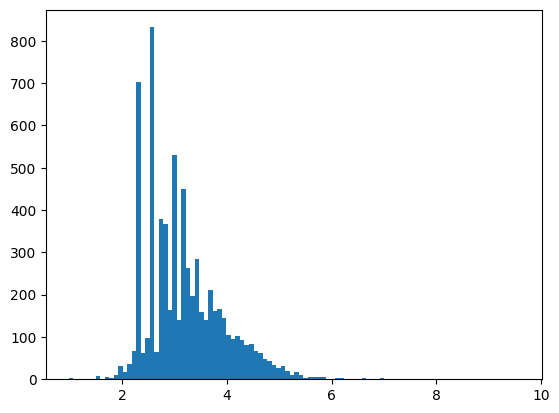

In [12]:
fig, ax = plt.subplots()
_ = ax.hist(np.log2(data["fold_enrichment"]), 100)

In [13]:
data["weights"] = np.log2(data["fold_enrichment"])

In [14]:
holdOutP = .1
n = len(seqs)
weights = data["weights"].tolist()

tmp = list(zip(seqs, weights))
random.shuffle(tmp)
seqs, weights = map(list, zip(*tmp))
        
trainGen = dataGen(seqs[:int((1 - holdOutP)*n)], posWeights=weights[:int((1 - holdOutP)*n)])
testGen = dataGen(seqs[int((1 - holdOutP)*n):],
                  seqsPerEpoch=1000)

Maximum sequence length = 200
4
Maximum sequence length = 200
10


In [15]:
w = 24
num_kernels = 1
use_bias = False
model = construct_model(num_kernels=num_kernels,
                        kernel_width=w,
                        use_bias=use_bias)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 4)]            0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, None, 4)              0         ['input_1[0][0]']             
 ise)                                                                                             
                                                                                                  
 lambda (Lambda)             (None, None, 4)              0         ['gaussian_noise[0][0]']      
                                                                                                  
 shared_conv (Conv1D)        (None, None, 1)              96        ['gaussian_noise[0][0]',  

In [16]:
epochs = 100
min_lr = .001
max_lr = .1
lr_decay = (min_lr / max_lr) ** (1 / epochs)
schedule = SGDRScheduler(min_lr=min_lr,
                             max_lr=max_lr,
                             steps_per_epoch=trainGen.__len__(),
                             lr_decay=lr_decay,
                             cycle_length=1,
                             mult_factor=1.0, 
                             shape="triangular")

swa = SWA(epochs)


# In[90]:


history = model.fit_generator(trainGen, 
                              steps_per_epoch = trainGen.__len__(), 
                              verbose=1, 
                              epochs=epochs,
                              workers=4,
                              callbacks = [schedule, swa], validation_data = testGen,
                              validation_steps = testGen.__len__())


Epoch 1/100


/tmp/ipykernel_3888451/2745372477.py:19: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(trainGen,
2024-04-09 15:18:55.740588: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-04-09 15:18:55.857426: W tensorflow/c/c_api.cc:305] Operation '{name:'beta_2/Assign' id:139 op device:{requested: '', assigned: ''} def:{{{node beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta_2, beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-09 15:18:56.017542: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/v/Assign' id:375 op devic

620/625 [============================>.] - ETA: 0s - batch: 309.5000 - size: 32.0000 - loss: 1.1550 - accuracy: 0.8362

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


625/625 [==============================] - 8s 13ms/step - batch: 312.0000 - size: 32.0000 - loss: 1.1522 - accuracy: 0.8369 - val_loss: 0.2608 - val_accuracy: 0.9042
Epoch 2/100
625/625 [==============================] - 8s 13ms/step - batch: 312.0000 - size: 32.0000 - loss: 0.9834 - accuracy: 0.8728 - val_loss: 0.2436 - val_accuracy: 0.8982
Epoch 3/100
625/625 [==============================] - 8s 13ms/step - batch: 312.0000 - size: 32.0000 - loss: 0.9723 - accuracy: 0.8776 - val_loss: 0.2523 - val_accuracy: 0.9204
Epoch 4/100
625/625 [==============================] - 8s 13ms/step - batch: 312.0000 - size: 32.0000 - loss: 0.9463 - accuracy: 0.8808 - val_loss: 0.2824 - val_accuracy: 0.8619
Epoch 5/100
625/625 [==============================] - 8s 13ms/step - batch: 312.0000 - size: 32.0000 - loss: 0.9497 - accuracy: 0.8787 - val_loss: 0.2668 - val_accuracy: 0.9113
Epoch 6/100
625/625 [==============================] - 8s 13ms/step - batch: 312.0000 - size: 32.0000 - loss: 0.9600 - acc

In [17]:
if use_bias:
    conv_weights, conv_bias = model.get_layer("shared_conv").get_weights()
else:
    conv_weights = model.get_layer("shared_conv").get_weights()[0]

In [19]:
AUCs = []
nSteps = 200
from sklearn.metrics import roc_auc_score
for i in range(num_kernels):
    tmp_conv_weights = np.zeros(conv_weights.shape)
    if use_bias:
        tmp_bias = np.zeros(num_kernels)
    tmp_conv_weights[:,:,i] = conv_weights[:,:,i]
    
    if use_bias:
        tmp_bias[i] = conv_bias[i]
    
    if use_bias:
        model.get_layer("shared_conv").set_weights([tmp_conv_weights, tmp_bias])
    else:
        model.get_layer("shared_conv").set_weights([tmp_conv_weights])
    yPred = model.predict(testGen, steps=nSteps)
    yTest = np.array(nSteps*([1 for i in range(16)] + [0 for i in range(16)]))
    AUCs.append(roc_auc_score(yTest, yPred))
print(AUCs)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-09 15:34:57.397287: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Sigmoid' id:70 op device:{requested: '', assigned: ''} def:{{{node dense_1/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[0.9663966796875001]


In [20]:
scan_model = construct_scan_model(conv_weights)

2024-04-09 15:35:08.112114: W tensorflow/c/c_api.cc:305] Operation '{name:'total_1/Assign' id:24840 op device:{requested: '', assigned: ''} def:{{{node total_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_1, total_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [21]:
anr = False
with open(TF + ".motifs.bed", "w") as f:
    for i in tqdm.trange(data.shape[0]):
        chrom, start, stop = data.iloc[i][:3]
        start, stop = int(start), int(stop)
        seq = genome[chrom][start:stop]
        
        encoded_seq = np.vstack((0.25*np.ones((w,4)), encode_sequence(seq), 0.25*np.ones((w,4))))
        encoded_seq_rc = encoded_seq[::-1,::-1]

        conv_for = scan_model.predict(np.expand_dims(encoded_seq, axis = 0), verbose=0)[0]
        conv_rc = scan_model.predict(np.expand_dims(encoded_seq_rc, axis = 0), verbose=0)[0]

        for k in range(num_kernels):
            if anr:
                matches_for = np.argwhere(conv_for[:,k] > 0)[:,0].tolist()
                matches_rc = np.argwhere(conv_rc[:,k] > 0)[:,0].tolist()
                for x in matches_for:
                    motif_start = x - w 
                    motif_end = motif_start + w
                    score = conv_for[x,k]
                    pfms[k] += encoded_seq[x:x+w,:]

                for x in matches_rc:
                    motif_end = x + w
                    motif_start = motif_end - w 
                    score = conv_rc[x,k] 
                    pfms[k] += encoded_seq_rc[x:x+w,:]
                    n_instances[k] += 1
                
            else:
                maxFor = np.max(conv_for[:,k])
                maxRC = np.max(conv_rc[:,k])

                if maxFor > 0 or maxRC > 0:
                    if maxFor > maxRC:
                        x = np.argmax(conv_for[:,k])
                        motif_start = x - w 
                        motif_end = motif_start + w
                        score = conv_for[x,k]
                        motifSeq = decode_sequence(encoded_seq[x:x+w,:])
                        print(chrom, start+motif_start, start+motif_end, k, score, "+", motifSeq, file=f, sep="\t")
                    else:
                        x = np.argmax(conv_rc[:,k])
                        motif_end = x + w
                        motif_start = motif_end - w 
                        score = conv_rc[x,k] 
                        motifSeq = decode_sequence(encoded_seq_rc[x:x+w,:])
                        print(chrom, stop-motif_start, stop-motif_start+w, k, score, "-", motifSeq, file=f, sep="\t")



  0%|                                                                                                 | 0/6672 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-09 15:35:11.565632: W tensorflow/c/c_api.cc:305] Operation '{name:'scan_conv/Conv1D/Squeeze' id:24835 op device:{requested: '', assigned: ''} def:{{{node scan_conv/Conv1D/Squeeze}} = Squeeze[T=DT_FLOAT, _has_manual_control_dependencies=true, squeeze_dims=[-3]](scan_conv/Conv1D)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
100%|█████████████████████████████████████████████████████████████████████████████████████| 6672/6672

In [22]:
motifs = pd.read_csv(TF + ".motifs.bed", sep="\t", names=["chrom", "start", "stop", "kernel", "score", "strand", "seq"])
motifs.head()

,chrom,start,stop,kernel,score,strand,seq
0,chr1,100133136,100133160,0,29.774160,-,GGCTCGCTTCCGGTGTCCAGCATC
1,chr1,100266231,100266255,0,25.063364,+,CCGCTTCTTCCGCTTTCTCGTCAG
2,chr1,100894865,100894889,0,27.334887,+,GCTCCACTTCCTGTCGGCCTAAAA
3,chr1,100896076,100896100,0,35.612114,-,CGCTTACTTCCGGCCCGGGCCGCG
4,chr1,1019764,1019788,0,28.902683,+,GCCGCACTTCCGGGGGGCCGCGGC


In [23]:
pfms = [np.zeros((w,4)) for i in range(num_kernels)]
nInstances = [0 for i in range(num_kernels)]
with open(TF + ".motifs.bed") as f:
    for line in f:
        split = line.strip().split("\t")
        chrom, start, stop, name, score, strand, seq = split
        pfms[int(name)] += encode_sequence(seq)
        nInstances[int(name)] += 1

In [24]:
with open(TF + ".meme", "w") as f:
    print("MEME version 4\n", file=f)
    print("ALPHABET= ACGT\n", file=f)
    print("strands: + -\n", file=f)
    print("Background letter frequencies", file=f)
    print("A 0.25 C 0.25 G 0.25 T 0.25\n", file=f)
    
    for i in range(num_kernels):
        print("MOTIF {}".format(i), file=f)
        print("letter-probability matrix: alength= 4 w= {} nsites= {}".format(w, nInstances[i]), file=f)
        pfm = pfms[i] + 1
        ppm = pfm/pfm.sum(axis=1, keepdims=True)
        for i in range(w):
            print(*ppm[i,:].flatten().tolist(), sep="\t", file=f)
        print(file=f)

In [25]:
with open(TF + ".TOMTOM.out", "w") as f:
    run(["tomtom", "--text", "-thresh", "1", TF + ".meme", "./misc/H12CORE_meme_format.meme"], stdout=f)


Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.952234
#   Estimated pi_0=0.954997


In [26]:
matches = []
pVals = []
for i in range(num_kernels):
    with open(TF + ".TOMTOM.out") as f:
        for line in f:
            split = line.strip().split("\t")
            try:
                if int(split[0]) == i:
                    matches.append(split[1])
                    pVals.append(float(split[3]))
                    break
            except:
                pass

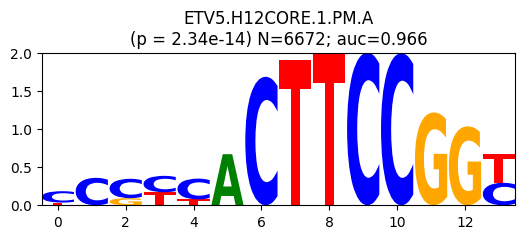

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(20,8), tight_layout=True)
toSave = {}
for i in range(num_kernels):
    ax = axes.flatten()[i]
    pfm = pfms[i] + 1
    ppm = pfm/pfm.sum(axis=1, keepdims=True)
    ppm = pd.DataFrame(ppm, columns=["A", "C", "G", "T"])
    trimmed_ppm = trim_ppm(ppm.values, min_info=0.0)[0]
    trimmed_ppm = pd.DataFrame(trimmed_ppm, columns=["A", "C", "G", "T"])
    ic = ppm.map(get_information_content)
    ic = trimmed_ppm.map(get_information_content)
    title = "{}\n(p = {:.2e}) N={}; auc={:.3f}".format(matches[i], pVals[i], nInstances[i], AUCs[i])
    logomaker.Logo(ic, ax=ax)
    ax.set_title(title)
    ax.set_ylim([0,2])
    toSave[i] = {"ppm" : ppm.values,
                 "trimmed_ppm" : trimmed_ppm,
                 "weights" : conv_weights[:,:,i],
                 "auc" : AUCs[i],
                 "p" : pVals[i],
                 "match" : matches[i],  
                 "n" : nInstances[i]}
    
for i in range(num_kernels,16):
    fig.delaxes(axes.flatten()[i])

In [29]:
with open(TF + ".pkl", "wb") as f:
    pickle.dump(toSave, f)

In [32]:
with open("test.txt", "w") as f:
    print(">{0} {0}_motif1".format(TF), file=f)
    for i in range(trimmed_ppm.shape[0]):
        print("\t".join(["%.5f" % v for v in toSave[0]["trimmed_ppm"].values[i,:]]), file=f)
    print(file=f)

In [33]:
!cat test.txt

>GABPA GABPA_motif1
0.15686	0.33849	0.23221	0.27244
0.17839	0.43961	0.19805	0.18395
0.12626	0.39106	0.30739	0.17529
0.06161	0.37191	0.21661	0.34987
0.14731	0.39997	0.15480	0.29792
0.56614	0.19655	0.21288	0.02442
0.00120	0.90563	0.01543	0.07774
0.02472	0.00225	0.00315	0.96989
0.00060	0.00150	0.00060	0.99730
0.00015	0.99910	0.00030	0.00045
0.00075	0.99685	0.00045	0.00195
0.00120	0.00315	0.75854	0.23712
0.00270	0.14530	0.69757	0.15443
0.04119	0.41013	0.09946	0.44922

